In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [7]:
train_X = pd.read_csv("train_X.csv").set_index('mid')
train_X_normalized = pd.read_csv("train_X_normalized.csv").set_index('mid')
train_X_extended = pd.read_csv("train_X_extended.csv").set_index('mid')
train_y = pd.read_csv('train_y.csv').set_index('mid')['radiant_win']

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
            self,
            a=0.5,
            *,
            estimator1,
            estimator2,
    ):
        self.a = a
        self.estimator1 = estimator1
        self.estimator2 = estimator2

    def fit(self, X, y):
        self.estimator1.fit(X, y)
        self.estimator2.fit(X, y)

        return self

    def predict(self, X):
        predict1 = self.estimator1.predict(X)
        predict2 = self.estimator2.predict(X)
        real_predict = self.a * predict1 + (1 - self.a) * predict2

        return real_predict

    def predict_proba(self, X):
        predict1 = self.estimator1.predict_proba(X)
        predict2 = self.estimator2.predict_proba(X)
        real_predict = self.a * predict1 + (1 - self.a) * predict2

        return real_predict

## (2 балла) Сравнение построенных моделей

После того как было построено много моделей, правильным продолжением является сравнение их между собой.  Воспользуйтесь диаграммой размаха ("ящик с усами") для сравнения алгоритмов между собой. Эту диаграмму можно построить при помощи [boxplot](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) из matplotlib либо через [обертку](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html) над ней из pandas.

**(2 балла) Задание 12.** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели, выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха. Все классификаторы должны быть изображены на одном графике.
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

Для всех моделей, кроме DecisionTree наилучший результат получился на расширенных данных.
Посчитаем значения по каждому фолду для оптимальных значений и построим общий график

## KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(p=1, n_neighbors=740)
score_knn = cross_val_score(knn, train_X_extended, train_y, cv=5, n_jobs=-1, scoring='roc_auc')
;

''

## DecisionTree

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier(criterion='entropy', max_depth=7)
score_dtc = cross_val_score(dtc, train_X, train_y, cv=5, n_jobs=-1, scoring='roc_auc')

## SGD

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd = SGDClassifier(loss='log', penalty='elasticnet')
score_sgd = cross_val_score(sgd, train_X_extended, train_y, cv=5, n_jobs=-1, scoring='roc_auc')

## RandomForest

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rft = RandomForestClassifier(criterion='entropy', n_estimators=1546)
score_rft = cross_val_score(rft, train_X_extended, train_y, cv=5, n_jobs=-1, scoring='roc_auc')
;

''

## Mix model

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


clf1 = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=1546, criterion='entropy', n_jobs=-1)

mix = MyClassifier(estimator1=clf1, estimator2=clf2, a=0.3)
score_mix = cross_val_score(mix, train_X_extended, train_y, cv=5, n_jobs=-1, scoring='roc_auc')


## boxplot

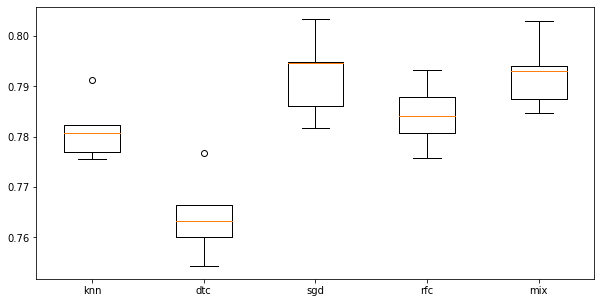

In [24]:
plt.rcParams["figure.figsize"]=10,5
plt.boxplot([score_knn, score_dtc, score_sgd, score_rft, score_mix])
plt.xticks(range(1, 6), ['knn', 'dtc', 'sgd', 'rfc', 'mix'])
plt.show()

## Выводы

Определим рассматриваемые гиперпараметры:
- KNN - n_neighbors, p
- DecisionTree - max_depth, criterion
- SGD - loss, penalty
- RandomForest - n_estimators, criterion, max_features

У каждого классификатора есть критически важный гиперпараметр, KNN - n_neighbors, DT - max_depth, SGD - loss, RF - n_estimators. Подбор этого параметра существенно сказывается на качестве модели, другие параметры могут незначительно улучшить.

Про работу с признаками. DecisionTree - единственная модель, для которой добавление новых признаков не принесло улучшение общего скора.

Дополнительно про смешанную модель - она не улучшила скор, но уменьшила общую дисперсию, что так же важно при проверки на реальных данных